<a href="https://colab.research.google.com/github/Atharva-K12/Memes-vs-Notes/blob/master/Numpy_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import libraries

In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import math

##Data loader

In [2]:
def loaddata(x):
    input_dir1="/content/drive/My Drive/Dataset_memes_vs_notes1/Memes"
    input_dir2="/content/drive/My Drive/Dataset_memes_vs_notes1/Notes"
    data0=[]
    data1 = []
    X_train=[]
    X_dev=[]
    X_test=[]
    Y_test=[]
    Y_train=[]
    Y_dev=[]
    c=1
    for file in os.listdir(input_dir1):
        img =Image.open(input_dir1 + '/' + file).convert('RGB')
        img=np.array(img.resize((100,100)),dtype='float64')
        data1.append([img,c])
    c=0
    for file in os.listdir(input_dir2):
        img =Image.open(input_dir2 + '/' + file).convert('RGB')
        img=np.array(img.resize((100,100)),dtype='float64')
        data0.append([img,c])
    np.random.seed(x)
    train = data0[:700] + data1[:700]
    dev = data0[700:750] + data1[700:750]
    test = data0[750:] + data1[750:]
    np.random.shuffle(train)
    np.random.shuffle(dev)
    np.random.shuffle(test)
    for x,y in train:
      X_train.append(x)
      Y_train.append(y)
    for x,y in dev:
      X_dev.append(x)
      Y_dev.append(y)
    for x,y in test:
      X_test.append(x)
      Y_test.append(y)
    print("Loaded!")
    return np.array(X_train),np.array(Y_train),np.array(X_dev),np.array(Y_dev),np.array(X_test),np.array(Y_test)

##Activation Functions

In [3]:
def sigmoid(Z):
  return 1/(1+np.exp(-Z)),Z
def relu(Z):
  return np.maximum(0,Z), Z
def relu_back(dA, Z):
  dZ = np.array(dA, copy=True)
  dZ[Z<= 0]=0
  return dZ
def sigmoid_back(dA, Z):
  s,t=sigmoid(Z)
  dZ=np.multiply(dA,np.multiply(s,1-s))
  return dZ

## Initialise Parameters

In [4]:
def parameters_init(dims):
    parameters = {}
    L = len(dims)
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(dims[l],dims[l-1])*np.sqrt(2/dims[l-1])
        parameters['b' + str(l)] = np.zeros((dims[l], 1))
    return parameters

In [5]:
def adam_init(parameters):
  L=len(parameters)//2
  v={}
  s={}
  for l in range(L):
    v["dW"+str(l+1)]=np.zeros(parameters["W"+str(l+1)].shape)
    v["db"+str(l+1)]=np.zeros(parameters["b"+str(l+1)].shape)
    s["dW"+str(l+1)]=np.zeros(parameters["W"+str(l+1)].shape)
    s["db"+str(l+1)]=np.zeros(parameters["b"+str(l+1)].shape)
  return v, s

##Forward Propagation

In [6]:
def forward_prop_calc(W,A,b,activation):
  c=0
  Activ={"relu":relu,"sigmoid":sigmoid}
  Z=np.dot(W,A)+b
  cache1=(A,W,b)
  A,cache2=Activ[activation](Z)
  r=np.all((A==0),axis=1)
  cache3=(cache1,cache2)
  return A,cache3
def forward_prop(X,parameters):
    cache=[]
    A=X
    L=len(parameters)//2
    for l in range(L-1):
      A_prev=A
      A,cache3=forward_prop_calc(parameters['W'+str(l+1)],A_prev,parameters['b'+str(l+1)],activation="relu")
      cache.append(cache3)
    AL,cache3=forward_prop_calc(parameters['W'+str(L)],A,parameters['b'+str(L)],activation="sigmoid")
    cache.append(cache3)
    return AL,cache

##Cost 

In [7]:
def cost_calc(AL,Y,parameters,lambd=0.1):
  l2=0
  for i in range(1,len(parameters)//2):
    l2+=np.sum(np.square(parameters['W'+str(i)]))
  cost=(-1/Y.shape[1])*(np.sum(np.multiply(Y,np.log(AL))+np.multiply(1-Y,np.log(1-AL))))+l2*lambd/(2*Y.shape[1])
  return cost

## Backward propagation

In [8]:
def back_prop_calc(dA,cache3,activation,lambd=0.1):
    cache1,cache2=cache3
    Activ={"relu":relu_back,"sigmoid":sigmoid_back}
    dZ=Activ[activation](dA,cache2)
    A_prev,W,b=cache1
    m=A_prev.shape[1]
    dW=(1/m)*np.dot(dZ,A_prev.T)+lambd*W/m
    db=(1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev=np.dot(W.T,dZ)
    return dA_prev,dW,db
def back_prop(AL,Y,cache,lambd=0.1):
    grads={}
    L=len(cache)
    m=AL.shape[1]
    Y=Y.reshape(AL.shape)
    dAL=-(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    cache3=cache[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)]=back_prop_calc(dAL,cache3,"sigmoid",lambd)
    for l in reversed(range(L-1)):
        cache3=cache[l]
        grads["dA"+str(l)],grads["dW"+str(l+1)],grads["db"+str(l+1)]=back_prop_calc(grads["dA"+str(l+1)],cache3,"relu",lambd)
    return grads

##Parameters Update

In [9]:
def adam_update(parameters,grads,v,s,t,alpha=0.001,beta1=0.9,beta2=0.999,epsilon=1e-8):
  L=len(parameters)//2
  for l in range(L):
    v["dW"+str(l+1)]=(beta1*v["dW"+str(l+1)]+(1-beta1)*grads["dW"+str(l+1)])/(1-beta1**t)
    v["db"+str(l+1)]=(beta1*v["db"+str(l+1)]+(1-beta1)*grads["db"+str(l+1)])/(1-beta1**t)
    s["dW"+str(l+1)]=(beta2*s["dW"+str(l+1)]+(1-beta2)*(grads["dW"+str(l+1)]**2))/(1-beta2**t)
    s["db"+str(l+1)]=(beta2*s["db"+str(l+1)]+(1-beta2)*(grads["db"+str(l+1)]**2))/(1-beta2**t)
    parameters["W"+str(l+1)]=parameters["W"+str(l+1)]-alpha*(v["dW"+str(l+1)]/(np.sqrt(s["dW"+str(l+1)])+epsilon))
    parameters["b"+str(l+1)]=parameters["b"+str(l+1)]-alpha*(v["db"+str(l+1)]/(np.sqrt(s["db"+str(l+1)])+epsilon))
  return parameters, v, s

##mini batches

In [10]:
def mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

#Model

In [21]:
def model(X,Y,parameters,v,s,alpha=0.001,mini_batch_size=64,beta1=0.9,beta2=0.999,epsilon = 1e-8,lambd=0.1,num_epochs=10):
    costs=[]
    mini_costs=[]
    t=0
    seed=10
    m=X.shape[1]
    print("Model Initiated!")
    for i in range(1,num_epochs+1):
        seed = seed + 1
        minibatches=mini_batches(X, Y, mini_batch_size, seed)
        total_cost=0
        for minibatch in minibatches:
            (minibatch_X,minibatch_Y)=minibatch
            AL,cache=forward_prop(minibatch_X,parameters)
            cost=cost_calc(AL,minibatch_Y,parameters,lambd)
            mini_costs.append(cost)
            total_cost+=cost
            grads=back_prop(AL,minibatch_Y,cache,lambd)
            t=t+1
            parameters,v,s=adam_update(parameters,grads,v,s,t,alpha,beta1,beta2,epsilon)
        cost_avg=total_cost/m
        alpha/=np.sqrt(i)
        print ("Cost after epoch %i: %f" %(i, cost_avg))
        costs.append(cost_avg)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.show()
    plt.plot(mini_costs)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.show()
    return parameters,v,s

##predict function

In [22]:
def predict(X, y, parameters,s):
  m = X.shape[1]
  p = np.zeros((m))
  AL, caches = forward_prop(X, parameters)
  for i in range(AL.shape[1]):
    if AL[0,i] > 0.5:
      p[i] = 1
    else:
      p[i] = 0
  Accuracy=np.mean((p[:]==y[:]))*100
  print( s+ " set Accuracy: "  + str(Accuracy)+"%")
  return Accuracy

##Implementation

In [23]:
def run():
    X_train,Y_train,X_dev,Y_dev,X_test,Y_test=loaddata(5)
    numpx=X_train.shape[1]
    X_train=X_train.reshape(X_train.shape[0], -1).T
    Y_train=Y_train.reshape(1,Y_train.shape[0])
    X_train=X_train/255
    X_test=X_test.reshape(X_test.shape[0], -1).T
    Y_test=Y_test.reshape(1,Y_test.shape[0])
    X_test=X_test/255
    X_dev=X_dev.reshape(X_dev.shape[0], -1).T
    Y_dev=Y_dev.reshape(1,Y_dev.shape[0])
    X_dev=X_dev/255
    dims=(numpx*numpx*3,730,250,95,33,1)
    parameters=parameters_init(dims)
    v,s=adam_init(parameters)
    parameters,v,s=model(X_train,Y_train,parameters,v,s,alpha=0.0001,mini_batch_size=64,beta1=0.9,beta2=0.999,epsilon = 1e-8,lambd=0.1,num_epochs=3)
    predictions_train=predict(X_train,Y_train,parameters,"Train")
    parameters,v,s=model(X_dev,Y_dev,parameters,v,s,alpha=0.0001,mini_batch_size=64,beta1=0.9,beta2=0.999,epsilon = 1e-8,lambd=0.1,num_epochs=3)
    predictions_dev=predict(X_dev,Y_dev,parameters,"Dev")
    predictions_test=predict(X_test,Y_test,parameters,"Test")

Loaded!
Model Initiated!
Cost after epoch 1: 0.038330
Cost after epoch 2: 0.036870
Cost after epoch 3: 0.036868


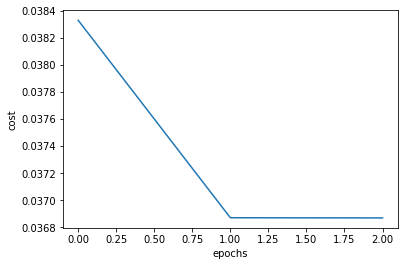

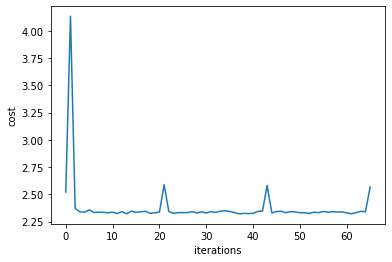

Train set Accuracy: 86.57142857142858%
Model Initiated!
Cost after epoch 1: 0.060081
Cost after epoch 2: 0.060189
Cost after epoch 3: 0.060142


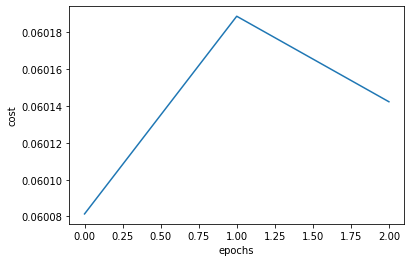

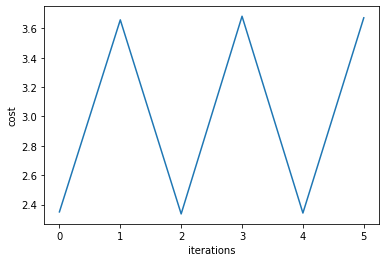

Dev set Accuracy: 86.0%
Test set Accuracy: 86.0%


In [24]:
run()